# Transformer

In [13]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.normalization_factor = d**0.5

    def forward(self, q, k, v, mask = None):
        """
            q : Query vector [BatchSize x (_) x Dim]
            k : Key Vector   [BatchSize x Seq Len x Dim], k.t : [BatchSize x Dim x Seq Len]
            v : Value Vector [BatchSize x Seq Len x Dim]

            mask : A mask is required for each sample of shape as  [(_) x Seq Len] 
                   i.e.[BatchSize x (_) x Seq Len]

            unnormalized attention = Q(K.T)
            normalized attention  = Q(K.T) / (d**0.5)
        """
        unnormalized_attn = F.softmax(torch.matmul(q, torch.transpose(k, -2, -1)), dim = -1)
        normalized_attn = unnormalized_attn / self.normalization_factor 
        # attention : [BatchSize x (_) x Seq Len]
        if (mask is not None):
            # The mask is an batch-wise element multiplication
            normalized_attn = torch.mul(mask, normalized_attn)
            
        #[BatchSize x (_) x Dim]
        attention_value = torch.matmul(normalized_attn, v) 
        return attention_value, normalized_attn

In [24]:
class Attention(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()

        self.query_weights = nn.Linear(input_dim, embedding_dim)
        self.key_weights   = nn.Linear(input_dim, embedding_dim)
        self.value_weights = nn.Linear(input_dim, embedding_dim)

        self.scaled_attention = ScaledDotProductAttention(embedding_dim)

    def forward(self, q, k, v, mask = None):
        q = self.query_weights(q)
        k = self.key_weights(k) 
        v = self.value_weights(v)

        attention, attention_weights = self.scaled_attention(q, k, v, mask = mask)
        return attention, attention_weights

In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads, embedding_dim, output_dim):
        super().__init__()
        assert (embedding_dim % num_heads == 0), f"embedding dim {embedding_dim} must be divisible by num heads {num_heads}"
        
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim // num_heads
        self.multihead_attention = [(Attention(input_dim, self.embedding_dim)) for _ in range(num_heads)]

        self.output_projection = nn.Linear(embedding_dim, output_dim)
    
    def forward(self, q, k, v, mask=None):
        attention_list, weights_list = [], []
        for attention_head in self.multihead_attention:
            attention, attention_weights = attention_head(q, k, v, mask)
            attention_list.append(attention)
            weights_list.append(attention_weights.unsqueeze(dim = 1))
        
        attention = torch.cat(attention_list, dim = -1)
        weights_list = torch.cat(weights_list, dim = 1)
        attention = self.output_projection(attention)
        return attention, weights_list

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, output_dim, num_heads):
        super().__init__()
        self.multi_head_attn = MultiHeadAttention(input_dim, num_heads, 
                                                  embedding_dim, 
                                                  output_dim)
        self.layer_norm_inter = nn.LayerNorm(output_dim)
        self.fc = nn.Sequential(*[
            nn.Linear(output_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim),
        ])
        self.layer_norm_final = nn.LayerNorm(output_dim)

    def forward(self, x, mask=None):
        attn, attn_weights = self.multi_head_attn(x, x, x, mask = mask)
        x = x + attn
        x = self.layer_norm_inter(x)
        fc_result = self.fc(x)
        x = self.layer_norm_final(fc_result + x)
        return x, attn_weights

In [27]:
class Decoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, output_dim, num_heads):
        super().__init__()
        self.multi_head_attn_1 = MultiHeadAttention(input_dim, num_heads, 
                                                  embedding_dim, 
                                                  output_dim)
        self.layer_norm_1 = nn.LayerNorm(output_dim)
        self.multi_head_attn_2 = MultiHeadAttention(output_dim, num_heads, 
                                                    output_dim, 
                                                    output_dim)
        self.layer_norm_2 = nn.LayerNorm(output_dim)
        self.fc = nn.Sequential(*[
            nn.Linear(output_dim, output_dim), 
            nn.ReLU(), 
            nn.Linear(output_dim, output_dim)
        ])
        self.layer_norm_final = nn.LayerNorm(output_dim)

    def forward(self, x, encoder, mask_encoder = None, mask_decoder=None):
        attn, attn_weights_dec = self.multi_head_attn_1(x, x, x, mask = mask_encoder)
        x = self.layer_norm_1(x + attn)
        attn, attn_weights_enc = self.multi_head_attn_2(x, encoder, encoder, mask = mask_decoder)
        x = self.layer_norm_2(x + attn)
        x = self.fc(x)
        x = self.layer_norm_final(x)
        return x, attn_weights_enc, attn_weights_dec

## Builduing the Tranformer architecture

In [28]:
class Transformer(nn.Module):
    def __init__(self, input_dim, embedding_dim, output_dim, num_heads):
        super().__init__()
        self.encoder_1 = Encoder(input_dim, embedding_dim, embedding_dim, num_heads)
        self.decoder_1 = Decoder(input_dim, embedding_dim, embedding_dim, num_heads)

        self.encoder_2 = Encoder(input_dim, embedding_dim, embedding_dim, num_heads)
        self.decoder_2 = Decoder(input_dim, embedding_dim, embedding_dim, num_heads)

        self.encoder_3 = Encoder(input_dim, embedding_dim, embedding_dim, num_heads)
        self.decoder_3 = Decoder(input_dim, embedding_dim, embedding_dim, num_heads)

        self.fc_connect = nn.Sequential(*[
            nn.Linear(embedding_dim, embedding_dim), 
            nn.ReLU(), 
            nn.Linear(embedding_dim, output_dim),
            nn.Softmax(dim = -1)
        ])

    def forward(self, x, outputs, mask_encoder=None):
        enc_1, _ = self.encoder_1(x, mask = mask_encoder)
        enc_2, _ = self.encoder_2(enc_1, mask = mask_encoder)
        enc_3, _ = self.encoder_3(enc_2, mask = mask_encoder) # shape [batch_size x seq_len x output_dim]

        # we need to add the last sequence of the encoder to initial sequence
        h = enc_3[:, -1].unsqueeze(1)  # shape [batch_size x 1 x output_dim]
        outputs = torch.cat([h, outputs], dim = -2) # shape [batch_size x (_)+1 x output_dim]
        
        # Shifts it by right and the encoder output is passed as input
        outputs = outputs[:, :-1] # shape [batch_size x (_) x output_dim]

        # Should be of shape [(_) x (seq_len)]
        mask_decoder = torch.tril(torch.ones(size=(outputs.size(1), x.size(1)), device = x.device))
        
        decoder_1, _, _ = self.decoder_1(outputs, enc_1, 
                                         mask_encoder = mask_encoder, mask_decoder = mask_decoder)
                                  
        decoder_2, _, _ = self.decoder_2(decoder_1, enc_2,
                                         mask_encoder = mask_encoder, mask_decoder = mask_decoder)
        
        decoder_3, attn_weights_enc, attn_weights_dec = self.decoder_3(decoder_2, enc_3, 
                                                             mask_encoder = mask_encoder, 
                                                             mask_decoder = mask_decoder)

        prediction = self.fc_connect(decoder_3)
        return prediction, attn_weights_enc, attn_weights_dec        

In [29]:
batch_size = 8
seq_len = 10

input_dim = 128
embedding_dim = 128
output_dim = 100
num_heads = 4

transformer = Transformer(input_dim, embedding_dim, output_dim, num_heads)

x = torch.randn(size=(batch_size, seq_len, input_dim))
outputs = torch.randn(size=(batch_size, seq_len-1, input_dim))

In [30]:
output, weights_enc, weights_dec = transformer(x, outputs)

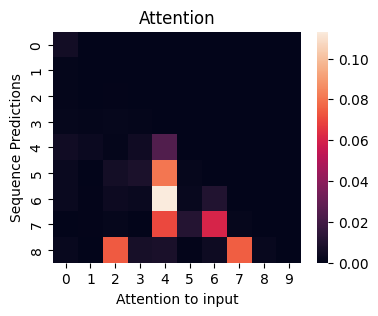

In [31]:
plt.figure(figsize=(4,3))
ax = sns.heatmap(weights_enc[0, 0].detach().numpy())
_ = ax.set( xlabel = 'Attention to input', 
            ylabel = 'Sequence Predictions', 
            title = "Attention")